# Autoregressive processes

- Once we learn the general equation and properties of the line / hyperplane we can turn around and perform various learning tasks - like regression and classification - using it as a model.  


- By the same token now that we have a basic understanding of how to model general ordered data, we can use those models to perform various learning tasks.  


- In this Section we use the generic fixed order dynamic system introduced previously to perform simple learning tasks on time series.  This is often referred to as *autoregressive modeling or prediction*.

Activate next cell to toggle code on and off

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is eåxported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')

# import custom lib
from mlrefined_libraries import recurrent_library as reclib

# import dataset path
datapath = '../../mlrefined_datasets/recurrent_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# Using limited memory dynamic systems for time series prediction

- A very natural way of dealing with time series prediction problems:


<ol>
  <li>"window" the data producing a set of input/output data</li>
  <li> train favorite standard ML scheme on input/output pairs</li>
  <li> to predict next future value feed in most recent window of series into trained model</li>
</ol>

- Making a training set of input/output data for a time series by "windowing" with a window size of $D = 3$ looks like this

<figure>
<p>
<img src= 'images/windowing_series.png' width="70%" height="70%" alt=""/>
</p>
<figcaption> <strong></strong> <em>  
</em>
</figcaption>
</figure>

- For example, using a linear `model` we press $x_{p}$ against a linear combination of its $D$ recent predecessors


- This takes the *exact* form of a *linear regression*, since we want to tune $w_0$ through $w_{D}$ so that the following holds

\begin{equation}
 w_0 + x_{p-1}w_1 + x_{p-2}w_2 + \cdots + x_{p-D}w_{D} \approx x_{p}
\end{equation}

- More compactly we can write this as 

\begin{equation}
\mathring{\mathbf{x}}_{p-1}^T\mathbf{w} \approx x_{p}
\end{equation}

where $
\mathring{\mathbf{x}}_{p-1}=\begin{bmatrix}
1 \\
x_{p-1}\\
\vdots\\
x_{p-D}
\end{bmatrix}
\,\,\,\,
\mathbf{w}=\begin{bmatrix}
w_{0}\\
w_{1}\\
\vdots\\
w_{D}
\end{bmatrix}
$

- Hence it makes sense to tune these weights by minimizing e.g., a Least Squares cost for linear regression

\begin{equation}
\frac{1}{P-D}\sum_{p=D}^{P}\left(\mathring{\mathbf{x}}_{p-1}^T\mathbf{w} - x_{p}\right)^2
\end{equation}

- This is standard *supervised learning*, denote by 

$$
\,\,\,\,\, \,\,\, \hat{y}_p:=\mathring{\mathbf{x}}_{p-1}^T\mathbf{w} \\
y_p:= x_p \\
\,\,\,\,\,  \,\,\,\,\,  \,\,\,\,\,  \,\,\,\,\,  \,\,  \ell\left(a,b\right) := \left(a-b \right)^2
$$

- We have a standard Least Squares regression

\begin{equation}
\frac{1}{P-D}\sum_{p=D}^{P}\ell\left(\hat{y}_p,y_p\right)
\end{equation}


- And we can extend this via nonlinear modeling precisely as we do with non time series data e.g., with a multilayer perceptron


- We simply replace the linear model $\text{model}\left(\mathbf{x},\mathbf{w}\right) = \mathring{\mathbf{x}}_{\,}^T\mathbf{w}$ with a nonlinear one $\text{model}\left(\mathbf{x},\Theta\right)$ built from units of a universal approximator (see [Chapters 10 - 13](https://github.com/jermwatt/machine_learning_refined))


- Another perspective: this approach turns the general framework of a [recurrence relation](https://jermwatt.github.io/control-notes/posts/recurrence_relations/Recurrence_relations.html) on its head, where proper parameters are *tuned* to data (instead of being set "by hand")

#### <span style="color:#a50e3e;">Example 1. </span>  Time series prediction using an autoregressive model

- Below we load in a time series dataset we will perform prediction on


- Note: we will first ["contrast normalize"](https://jermwatt.github.io/control-notes/posts/zca_sphereing/ZCA_Sphereing.html) this series - that is we mean center and re-scale by its standard deviation

<IPython.core.display.Javascript object>


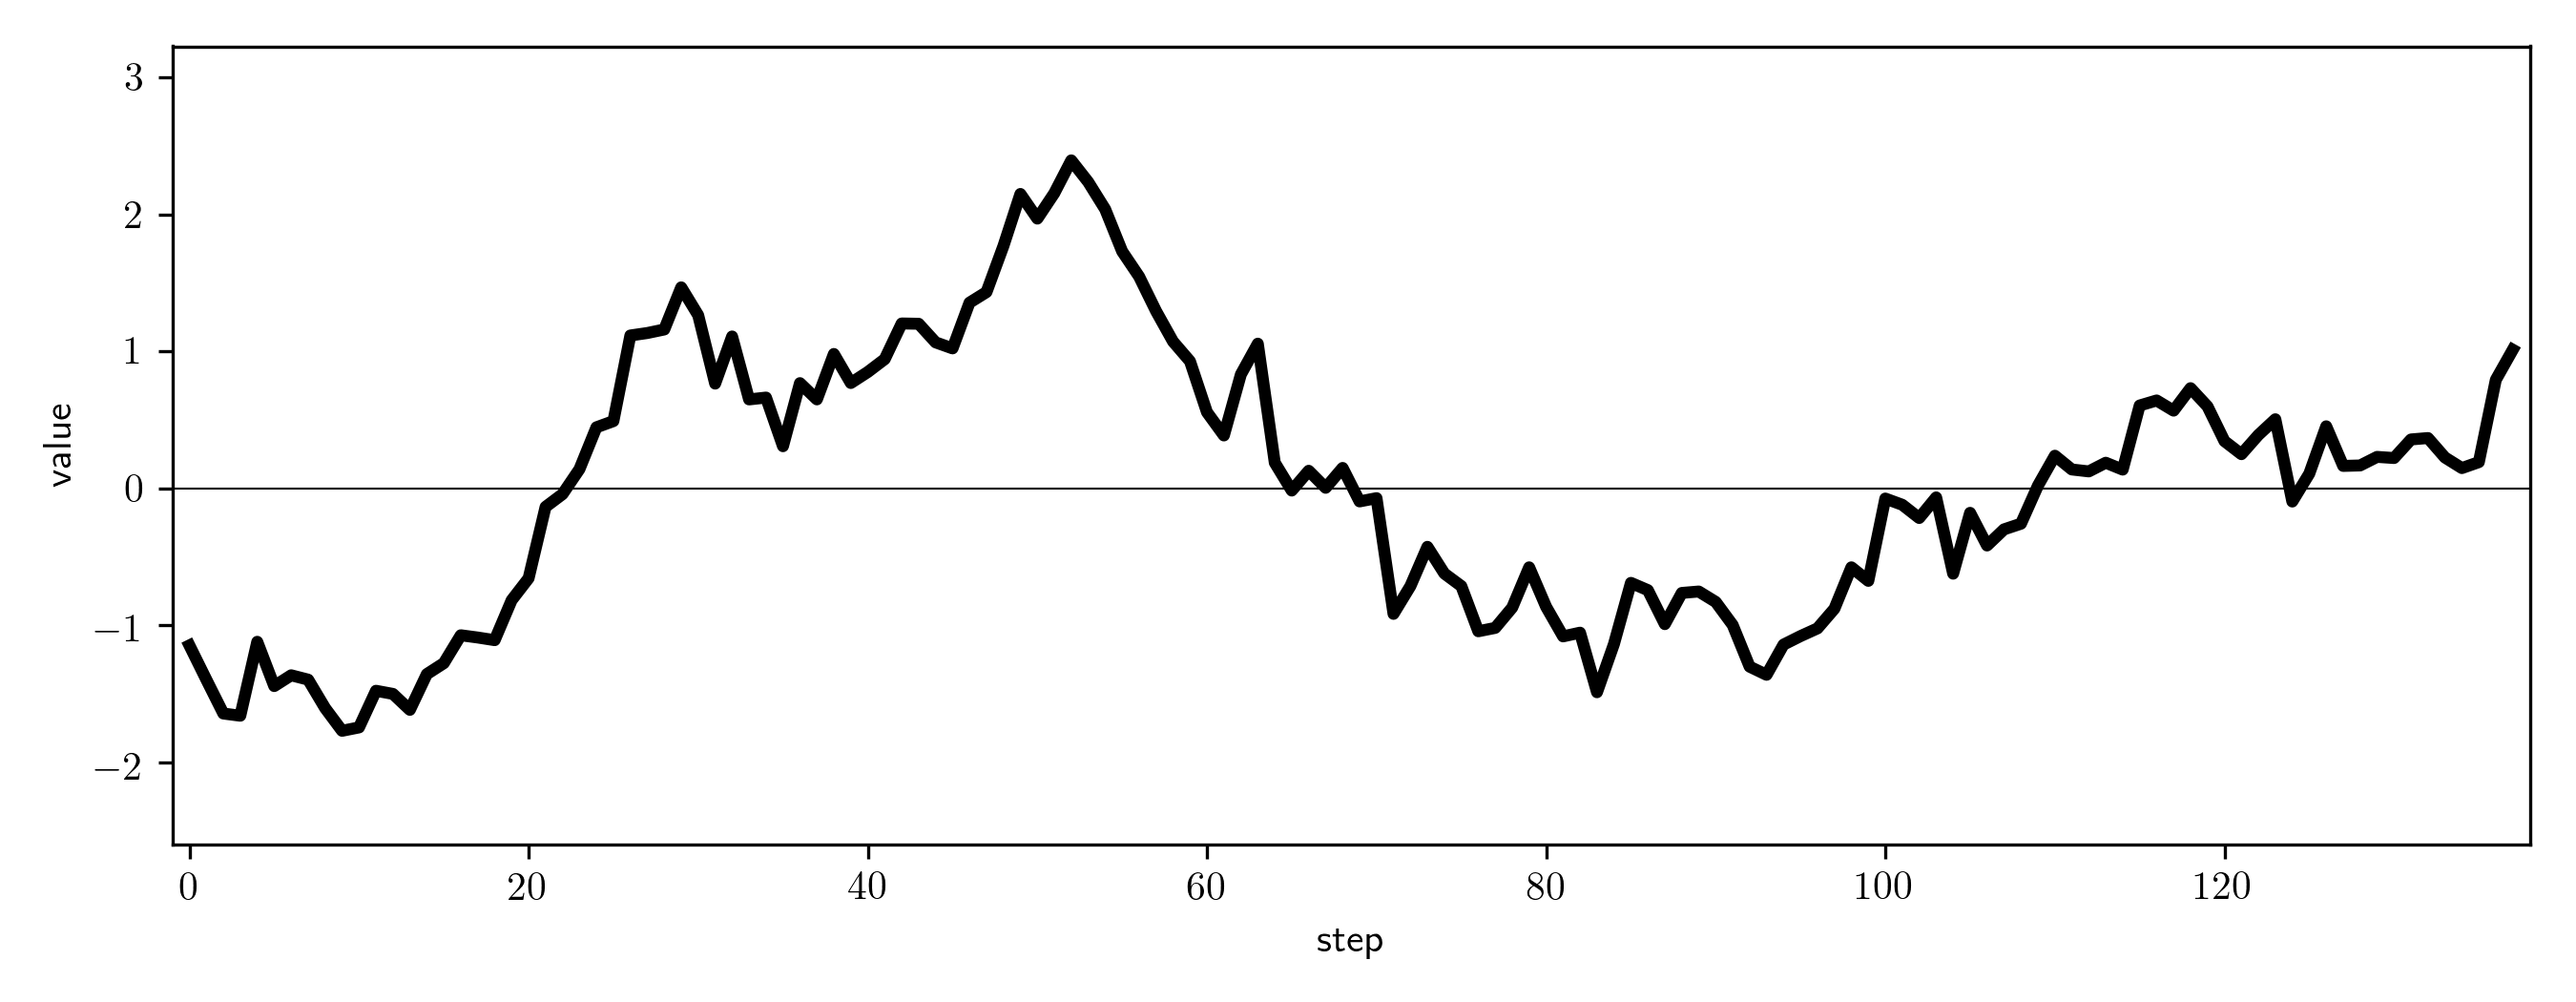

In [3]:
## This code cell will not be shown in the HTML version of this notebook
# load in driver
csvname = datapath + 'normalized_apple_prices.csv'
x_series = np.loadtxt(csvname,delimiter = ',')[np.newaxis,:]

# standard normalize input series
normalizer,inverse_normalizer = reclib.time_series_lib.normalizers.standard(x_series)
x_series = normalizer(x_series)

# Plot the standard normalized series
reclib.time_series_lib.fixed_order_plotters.plot_sequences(x_series)

- Next we choose an order for modeling, here we will use $D = 5$, and we produce a set of input/output data out of our time series as detailed above


- We can then use a [standard machine learning techniques](https://github.com/jermwatt/machine_learning_refined) - including [standard normalization](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html) the feature transforms like [multilayer perceptrons](https://jermwatt.github.io/machine_learning_refined/notes/13_Multilayer_perceptrons/13_2_Multi_layer_perceptrons.html), etc., - to learn an autoregressive model to this data to perfrom time series prediction


- Here we use the entire series as training, and tune a linear model via gradient descent

<IPython.core.display.Javascript object>


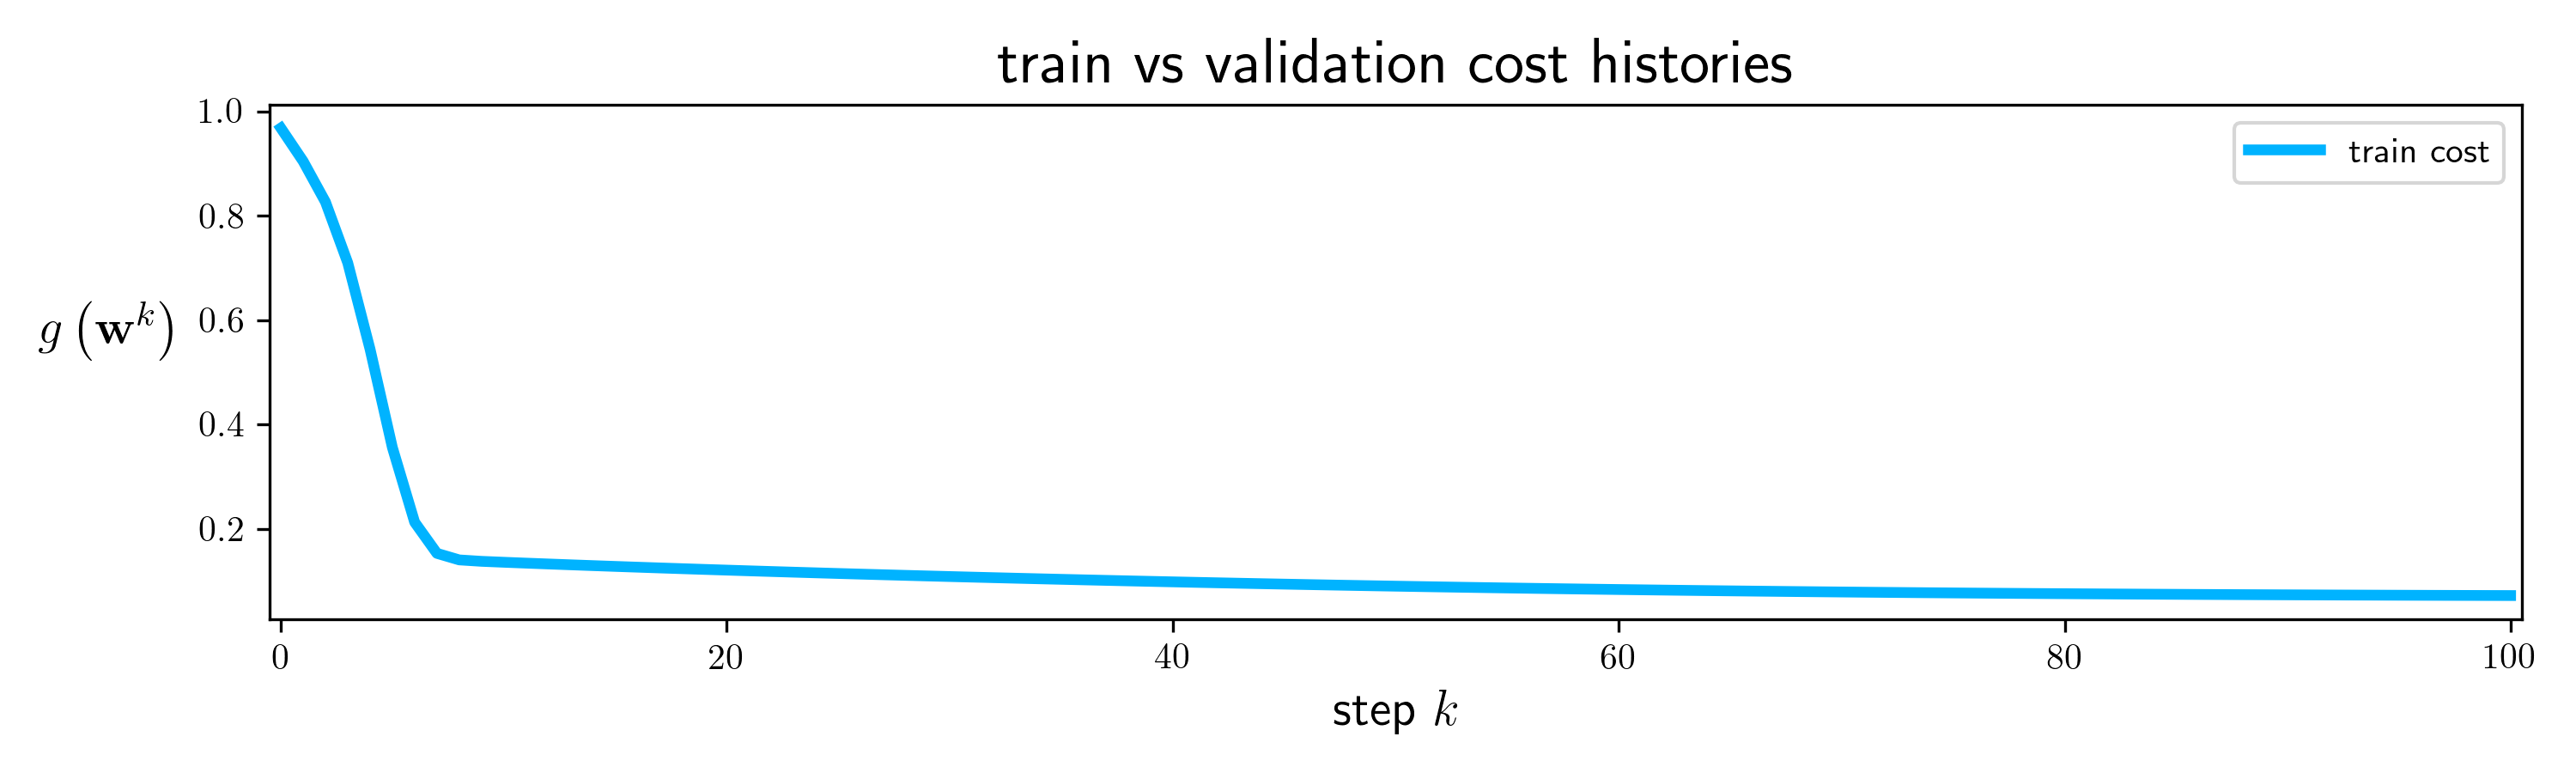

In [4]:
# This code cell will not be shown in the HTML version of this notebook
# create windowed series
order = 5
x,y = reclib.time_series_lib.utils.window_series(x_series,order = order)

# initialize with input/output data
mylib1 = reclib.time_series_lib.basic_lib.super_setup.Setup(x,y)

# perform preprocessing step(s) - especially input normalization
mylib1.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib1.make_train_val_split(train_portion = 1)

# choose cost
mylib1.choose_cost(name = 'least_squares')

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [1]
mylib1.choose_features(feature_name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'linear',scale = 0.1)

# fit an optimization
mylib1.fit(max_its = 100,alpha_choice = 10**(-1),verbose = False)

# show cost function history
mylib1.show_histories()

- Lets take a look - the series is plotted below along with the training fit in blue

<IPython.core.display.Javascript object>


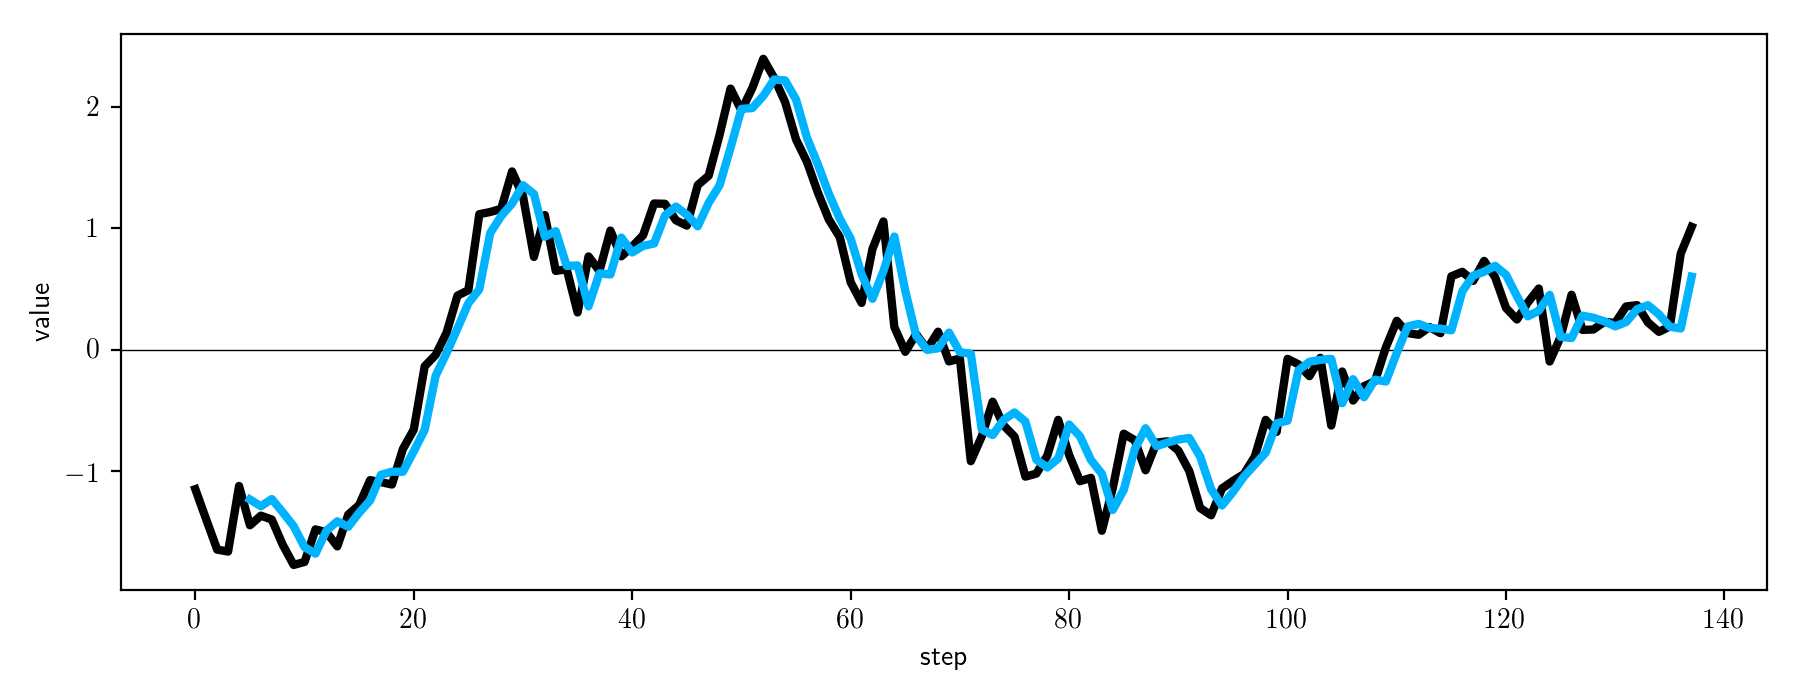

In [14]:
# Plot the standard normalized series and its training fit
reclib.time_series_lib.fixed_order_plotters.plot_train_val_sequences(mylib1,x_series)

# Cross-validation for time series

- With an (assumed) i.i.d. dataset we split our data into training and validation sets [*randomly*](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_3_Real_approximation.html)


- But this doesn't make sense with time series data.  Why?  Because validation data is supposed to model data, generated by the same process, that we will receive in the future


- Time series data doesn't arrive in this fashion - it arrives in contiguous chunks

- So cutting out validation data at random we take out a *contiguous portion* 



- For example, we can take the first large contiguous chunk of the series as training, and validate on a final contiguous portion 


- In terms of what portion of the data to assign to training / validation, the same rules of thumb still hold from ['standard' machine learning](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_3_Real_approximation.html) (e.g., 60% - 90% commonly used to train, the remainder for validation)


- In terms of efficient cross-validation schemes - typically regularization-based methods like early-stopping are used (to decide on the proper model parameter settings based on minimum validation error)

#### <span style="color:#a50e3e;">Example 2. </span>  Early stopping based cross-validation 

- Below is an example where we lop off the last third of the previously shown time series example for validation


- We use a linear model, tune its parameters via gradient descent, and use early stopping to make the final parameter choice


- The training fit is shown in blue, and validation in yellow

<IPython.core.display.Javascript object>


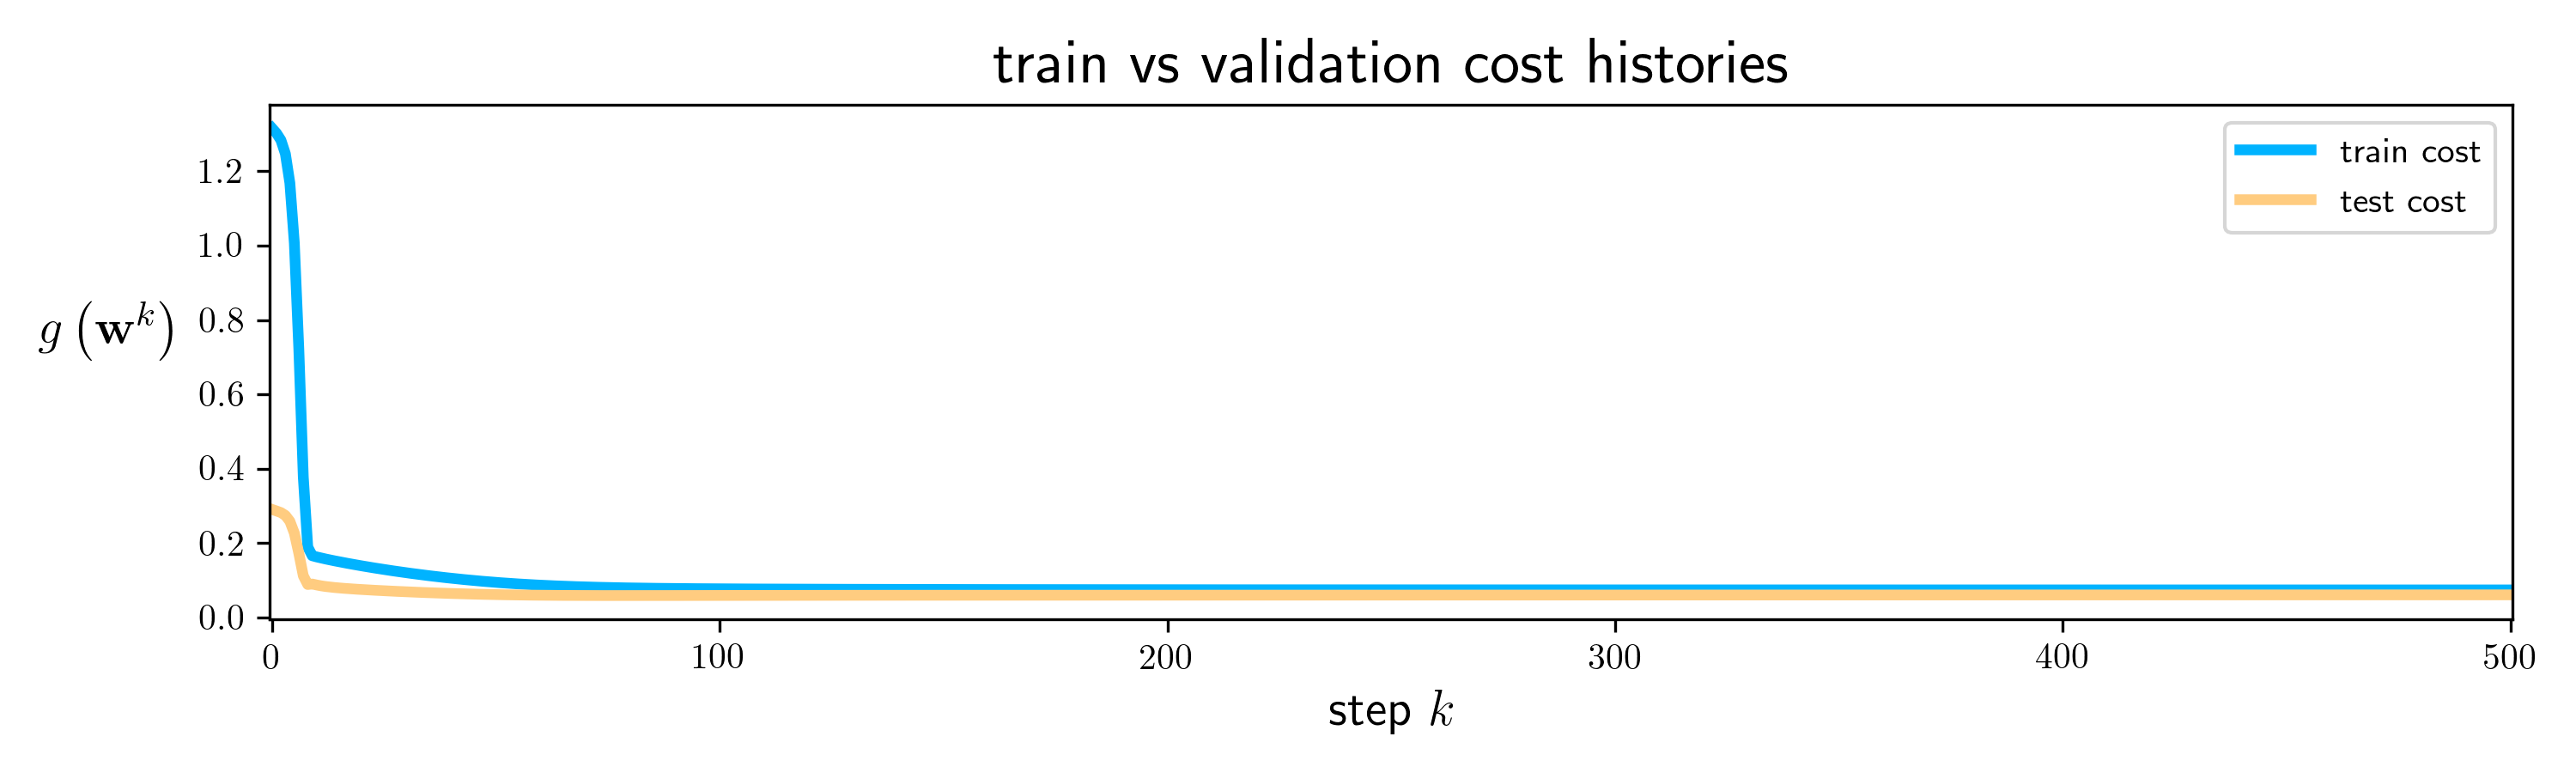

In [5]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib2 = reclib.time_series_lib.basic_lib.super_setup.Setup(x,y)

# perform preprocessing step(s) - especially input normalization
mylib2.preprocessing_steps(normalizer = 'standard')

# split into training and validation sets
mylib2.make_train_val_split(train_portion = 0.66)

# choose cost
mylib2.choose_cost(name = 'least_squares')

# choose dimensions of fully connected multilayer perceptron layers
layer_sizes = [1]
mylib2.choose_features(feature_name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'linear',scale = 0.1)

# fit an optimization
mylib2.fit(max_its = 500,alpha_choice = 10**(-1),verbose = False)

# show cost function history
mylib2.show_histories()

- We can then choose the best model and weights based on lowest validation error.


- Lets take a look - the series is plotted by the next cell.


- The training fit is shown in blue, validation shown in yellow.

<IPython.core.display.Javascript object>


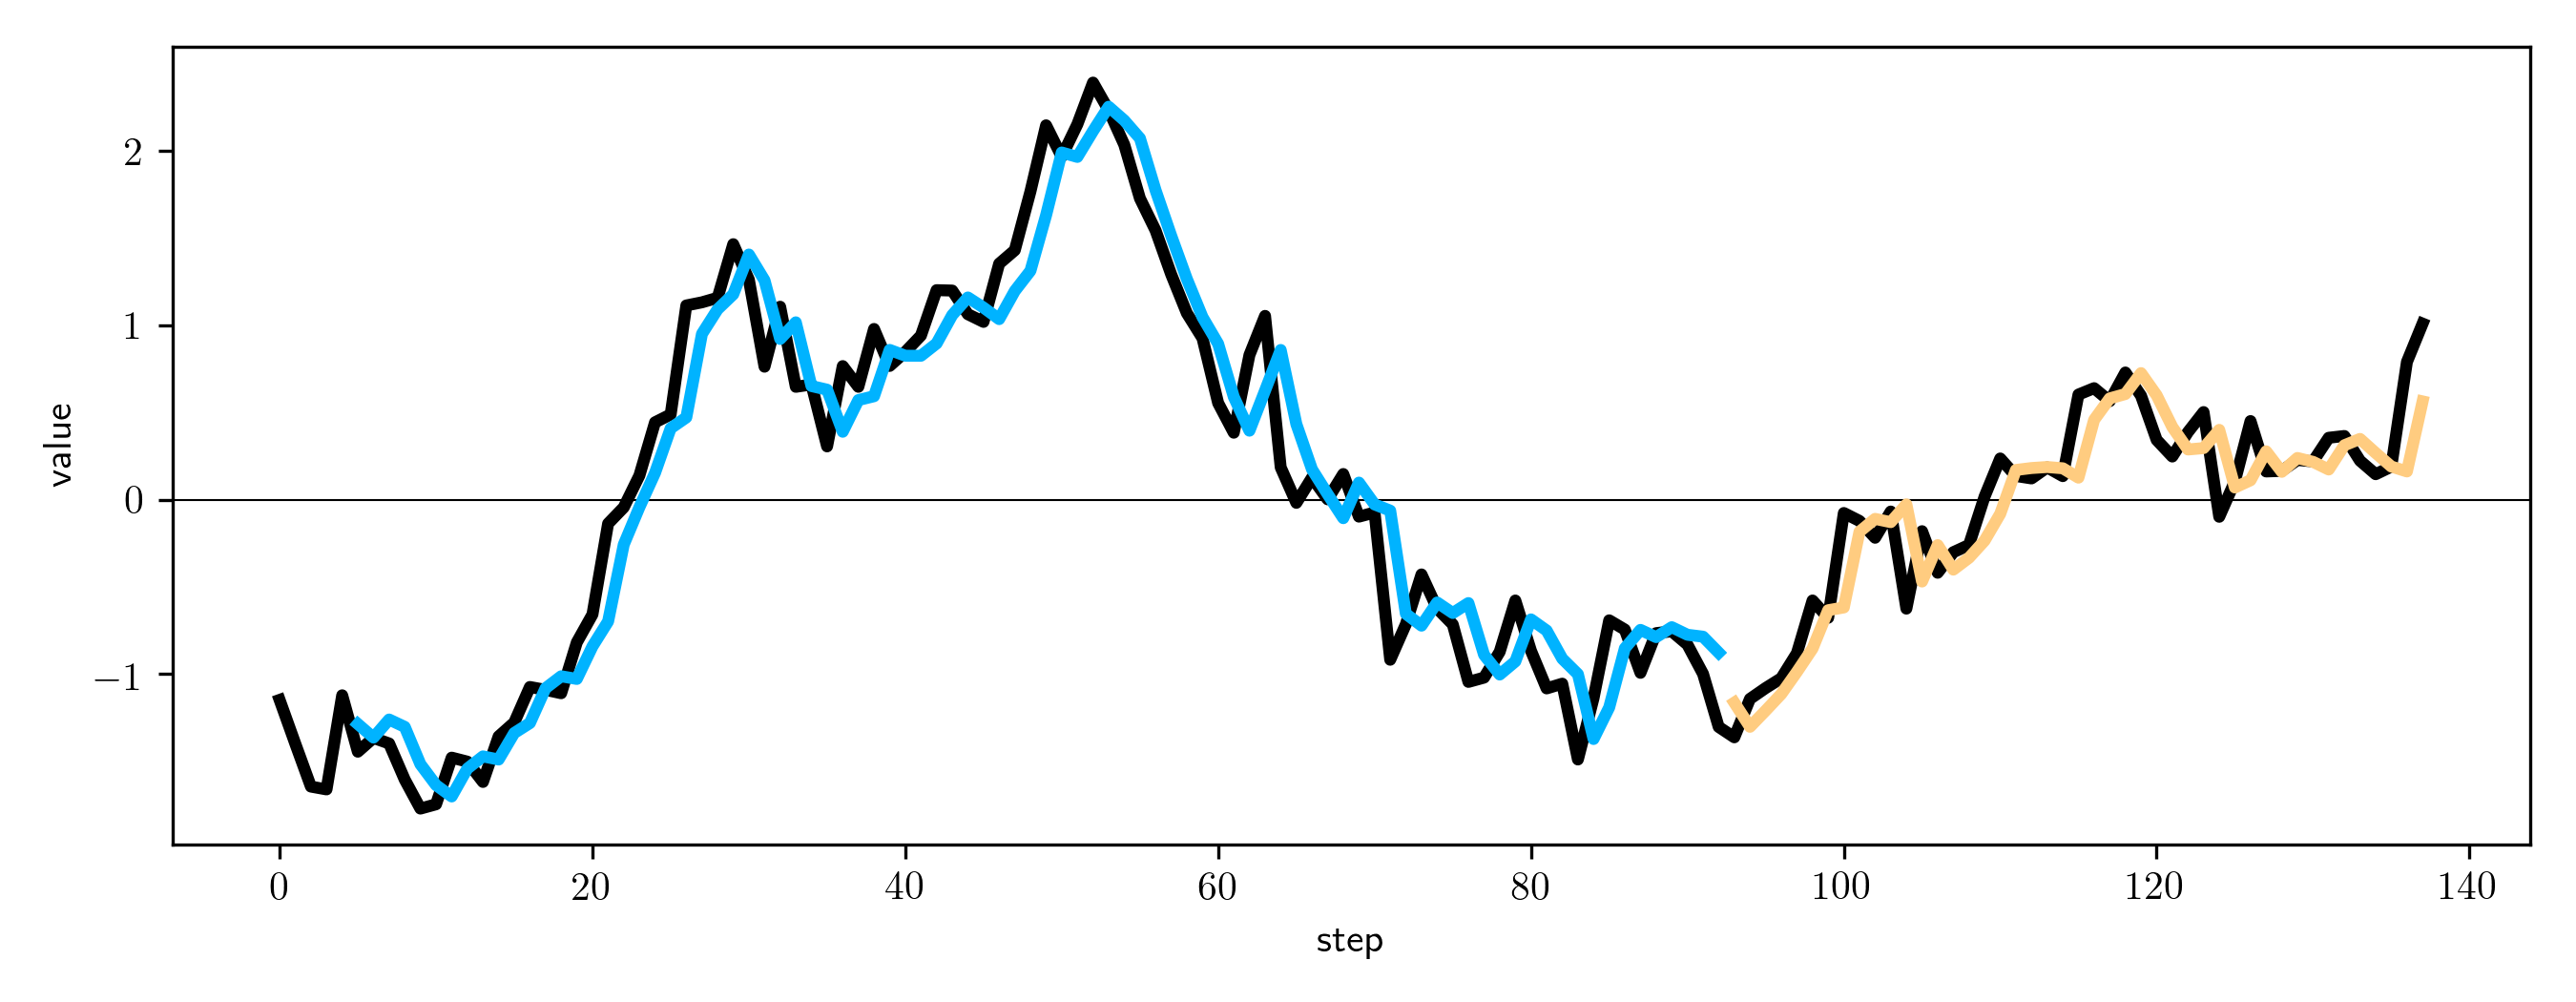

In [6]:
# Plot the standard normalized series
reclib.time_series_lib.fixed_order_plotters.plot_train_val_sequences(mylib2,x_series)

# Using a trained model as a recurrence relation or "generative model"

- With a trained model in hand, we can then use it as a [recurrence relation](https://jermwatt.github.io/control-notes/posts/recurrence_relations/Recurrence_relations.html) or "generative model" to produce predictions as far forward in the future as we like


- How do we do this if we - in order to make a single prediction - we need a contiguous window of the actual series?  


- By treating the previously *predicted values* as real elements of the series, as shown below for a prototypical series and window length $D = 3$.


<figure>
<p>
<img src= 'images/generation.png' width="120%" height="150%" alt=""/>
</p>
<figcaption> <strong></strong> <em>  
</em>
</figcaption>
</figure>

- This provides *very rough* prediction accuracy, since using the model as a generator means eventually it takes in all of its own predictions as input (which eventually degrades its predictive power)

<IPython.core.display.Javascript object>


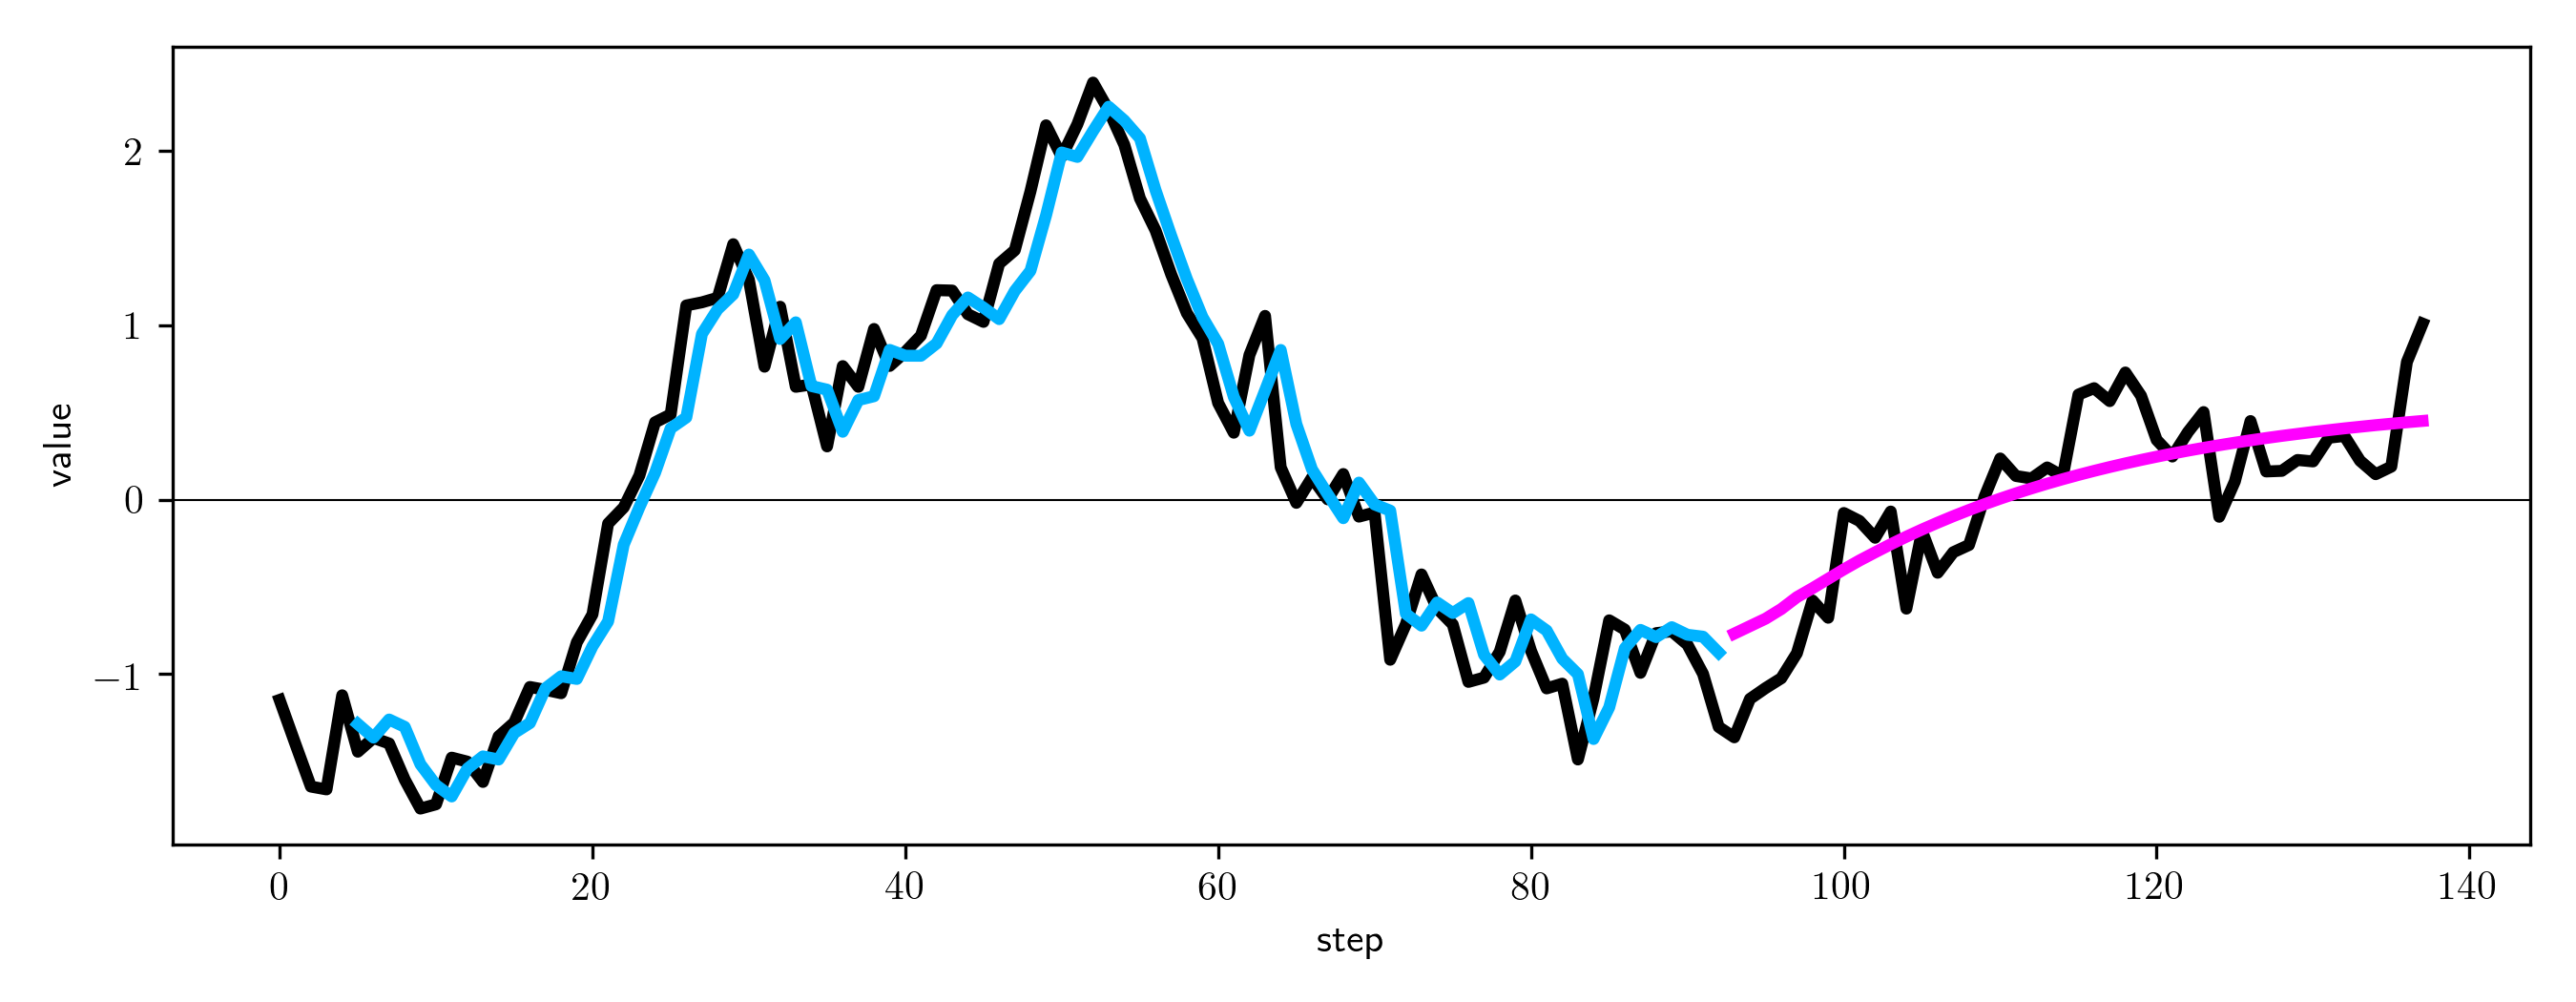

In [7]:
# Plot the standard normalized series
reclib.time_series_lib.fixed_order_plotters.plot_train_gen_sequences(mylib2,x_series)

# Time series classification 

- Precisely the same approach outlined above holds if a time series consists of *discrete* values in a fixed range


- The differences are only technical: (predicted) output are interpreted as "labels", and classification cost functions (see [Chapters 6 and 7](https://github.com/jermwatt/machine_learning_refined)) are used in place of regression costs like Least Squares


- So, in other words, the autoregressive approach to time series prediction with discrete values transforms the problem into a version of the 'standard' classification scheme


- One-hot encoding of discrete time series values is a common pre-processing step prior to prediction, as we outline for the case of Markov chains below

#### <span style="color:#a50e3e;">Example 3. </span>  Markov chains

- In our post on [Markov Chains](https://jermwatt.github.io/control-notes/posts/markov_chains/Markov_chains.html#one-hot) we saw (using one-hot encoded words or characters) the dynamic system describing a Markov Chain takes the form of a [moving average](https://jermwatt.github.io/control-notes/posts/moving_averages/Moving_averages.html) histogram

\begin{equation}
\,\,\,  \,\,\,  \,\,\, \,\,\,\,  \,\,\,\,\, \,\,\,  \mathbf{z}_p = \frac{\mathbf{x}_{p-1}+\mathbf{x}_{p-2} +\,...\,+\mathbf{x}_{p-D}}{D}\\
\end{equation}

- To determine the next predicted element we then simply compute the index of the largest value of this histogram as

\begin{equation}
h_p = \underset{j}{\text{argmax}}\,\, \left(\mathbf{z}_p\right).
\end{equation}


- To keep everything in terms of one-hot encodings, we can then one-hot encode this predicted index as

\begin{equation}
\mathbf{h}_p = \text{encoder}\left(h_p\right).
\end{equation}

- If we 'flip this on its head', we can replace the fixed moving average process with a parameterized model of our choosing.  


- For example a simple linear model would take the form


\begin{equation}
\mathbf{z}_p = w_0 + w_1\textbf{x}_{p-1} + w_2\textbf{x}_{p-2} + \cdots + w_{D}\textbf{x}_{p-D} 
\end{equation}



- The output of this system is then a *predicted output* $\hat{y}_p$ and its one-hot encoded version $\hat{\mathbf{y}}_p$

\begin{equation}
\hat{y}_p = \underset{j}{\text{argmax}}\,\, \left(\mathbf{z}_p\right) \\
\, \hat{\mathbf{y}}_p = \text{encoder}\left(\hat{y}_p\right).
\end{equation}

- The *predicted output* $\hat{\mathbf{y}}_p$ and the *true output* $\mathbf{y}_p$ (the next true character in the text $\mathbf{x}_{p+1}$) are both one-hot encoded vectors.  Thus they are both [one-hot encoded or 'categorical' *labels*](https://jermwatt.github.io/machine_learning_refined/notes/7_Linear_multiclass_classification/7_5_Categorical.html) in the jargon of machine learning.


- To tune model weights then perform multi-class classification, and minimize an appropriate cost $\ell$ that compares predicted to actual label

\begin{equation}
\frac{1}{P-D}\sum_{p=D}^{P}\ell\left(\hat{\mathbf{y}}_p,\mathbf{y}_p\right)
\end{equation}


- Note too that the $\text{argmax}$ operation here is a fundamental instance of the ['fusion rule'](https://jermwatt.github.io/machine_learning_refined/notes/7_Linear_multiclass_classification/7_2_OvA.html) of multi-class classification


- So - in other words - as an autoregressive process / form the ML point of view, a Markov Chain is an instance of standard multi-class classification